# ML Models — Rossmann Store Sales

### Why ML over ARIMA?
| ARIMA | ML (RF / XGBoost) |
|---|---|
| Univariate only | Uses all engineered features |
| One model per store | One model for all 1115 stores |
| Linear relationships | Captures non-linear patterns |
| Ignores Promo, holidays | Uses Promo, holidays, lags, rolling stats |

### Plan
1. Load featured data
2. Prepare X / y
3. Train Random Forest
4. Train XGBoost
5. Evaluate both — MAE & RMSE
6. Feature importance
7. Save models

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (14, 5), 'axes.titlesize': 13})

os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

RANDOM_SEED = 42
print('Imports done ✅')

Imports done ✅


## 2. Load Data

In [2]:
train_df = pd.read_csv('../data/processed/train_featured.csv', parse_dates=['Date'])
val_df   = pd.read_csv('../data/processed/val_featured.csv',   parse_dates=['Date'])

print(f'Train : {train_df.shape}')
print(f'Val   : {val_df.shape}')
train_df.head(3)

Train : (675958, 98)
Val   : (168380, 98)


,Store,Date,Sales,Sales_log,Promo,Promo2,IsPromo2Active,WeeksSincePromo2,Promo_x_Monday,Promo_x_Weekend,...,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Store_SalesMean,Store_SalesMedian,Store_SalesStd,Store_SalesMax,Store_SalesMin,Store_PromoRate,CompDist_WasNull
0,1,2013-01-02,5530,8.618124,0,0,0,-1.0,0,0,...,False,False,False,4759.096031,4647.0,1012.106393,9528,2362,0.448143,0
1,1,2013-01-03,4327,8.372861,0,0,0,-1.0,0,0,...,False,False,False,4759.096031,4647.0,1012.106393,9528,2362,0.448143,0
2,1,2013-01-04,4486,8.408940,0,0,0,-1.0,0,0,...,True,False,False,4759.096031,4647.0,1012.106393,9528,2362,0.448143,0


## 3. Prepare Features & Target

In [4]:
# Load feature list saved in notebook 02
feature_list = pd.read_csv('../data/processed/feature_list.csv')['feature'].tolist()

# Keep only features that exist in the dataframe
feature_cols = [f for f in feature_list if f in train_df.columns]

print(f'Total features : {len(feature_cols)}')

Total features : 94


In [5]:
TARGET = 'Sales_log'   # predict log(Sales), then expm1 back to Sales

X_train = train_df[feature_cols].fillna(0)
y_train = train_df[TARGET]

X_val   = val_df[feature_cols].fillna(0)
y_val   = val_df[TARGET]

# Actual sales (original scale) for evaluation
y_val_actual = np.expm1(val_df[TARGET].values)

print(f'X_train : {X_train.shape}')
print(f'X_val   : {X_val.shape}')

X_train : (675958, 94)
X_val   : (168380, 94)


## 4. Evaluation Helper

In [6]:
def evaluate(actual, predicted, label='Model'):
    mae  = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    print(f'\n=== {label} ===')
    print(f'  MAE  : {mae:>10,.2f}')
    print(f'  RMSE : {rmse:>10,.2f}')
    print(f'  MAPE : {mape:>9.2f}%')
    return {'Model': label, 'MAE': round(mae, 2), 'RMSE': round(rmse, 2), 'MAPE': round(mape, 2)}

## 5. Random Forest

In [7]:
print('Training Random Forest...')

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=10,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rf_model.fit(X_train, y_train)
print('Random Forest trained ✅')

Training Random Forest...
Random Forest trained ✅


In [8]:
# Predict & evaluate
rf_pred_log  = rf_model.predict(X_val)
rf_pred      = np.expm1(rf_pred_log)

results = []
r_rf = evaluate(y_val_actual, rf_pred, label='Random Forest')
results.append(r_rf)


=== Random Forest ===
  MAE  :     748.71
  RMSE :   1,115.93
  MAPE :     10.91%


In [9]:
results

[{'Model': 'Random Forest',
  'MAE': 748.71,
  'RMSE': np.float64(1115.93),
  'MAPE': np.float64(10.91)}]

## 6. XGBoost

In [10]:
print('Training XGBoost...')

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print('XGBoost trained ✅')

Training XGBoost...
XGBoost trained ✅


In [11]:
# Predict & evaluate
xgb_pred_log = xgb_model.predict(X_val)
xgb_pred     = np.expm1(xgb_pred_log)

r_xgb = evaluate(y_val_actual, xgb_pred, label='XGBoost')
results.append(r_xgb)


=== XGBoost ===
  MAE  :     647.59
  RMSE :     942.15
  MAPE :      9.33%


## 7. Compare with ARIMA Baseline

In [12]:
# ARIMA best result from notebook 03 (Store 1, manual ARIMA(2,1,2))
# Add manually from your notebook 03 output
arima_result = {'Model': 'ARIMA(2,1,2) — Store 1', 'MAE': None, 'RMSE': None, 'MAPE': None}
# ↑ Fill in the MAE/RMSE/MAPE values you got from notebook 03
# e.g. arima_result = {'Model': 'ARIMA(2,1,2)', 'MAE': 850.12, 'RMSE': 1120.45, 'MAPE': 12.3}
results.append(arima_result)

results_df = pd.DataFrame(results)
print('\n=== Full Model Comparison ===')
print(results_df.to_string(index=False))


=== Full Model Comparison ===
                 Model    MAE    RMSE  MAPE
         Random Forest 748.71 1115.93 10.91
               XGBoost 647.59  942.15  9.33
ARIMA(2,1,2) — Store 1    NaN     NaN   NaN


## 8. Forecast Plot — Actual vs Predicted

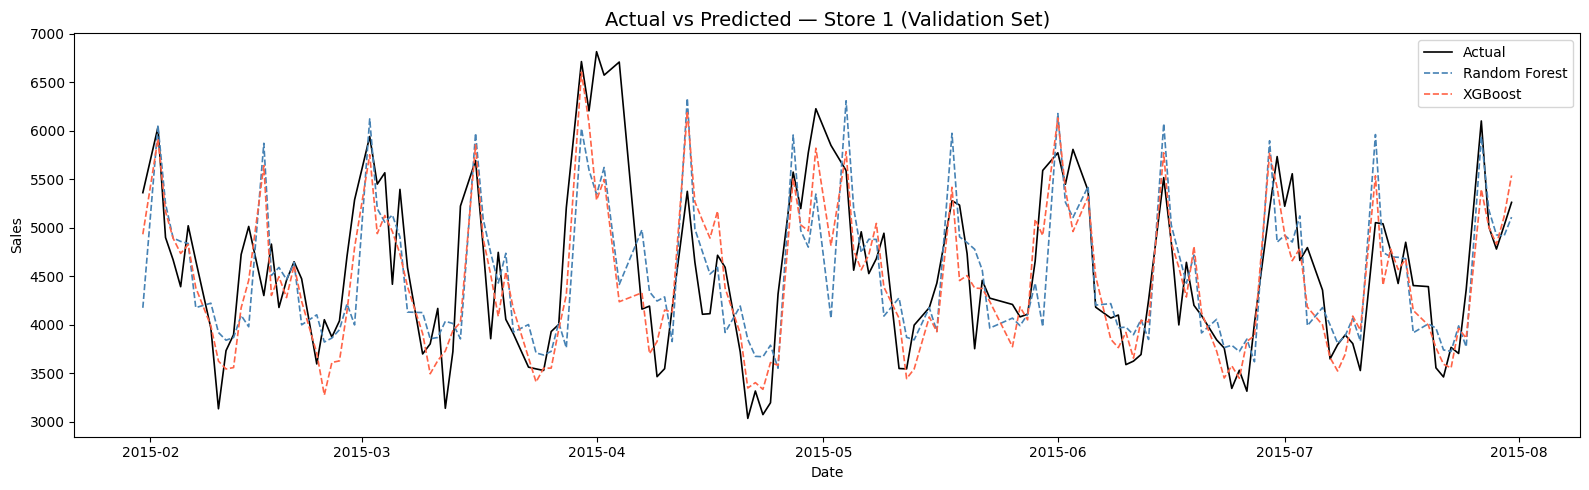

In [13]:
# Plot for a single store to keep it readable
STORE_ID = 1
store_mask = val_df['Store'] == STORE_ID

dates_s    = val_df.loc[store_mask, 'Date'].values
actual_s   = y_val_actual[store_mask.values]
rf_pred_s  = rf_pred[store_mask.values]
xgb_pred_s = xgb_pred[store_mask.values]

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(dates_s, actual_s,   color='black',    linewidth=1.2, label='Actual')
ax.plot(dates_s, rf_pred_s,  color='steelblue',linewidth=1.2, linestyle='--', label='Random Forest')
ax.plot(dates_s, xgb_pred_s, color='tomato',   linewidth=1.2, linestyle='--', label='XGBoost')

ax.set_title(f'Actual vs Predicted — Store {STORE_ID} (Validation Set)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/forecast_plot.png', dpi=150)
plt.show()

## 9. MAE & RMSE Bar Chart

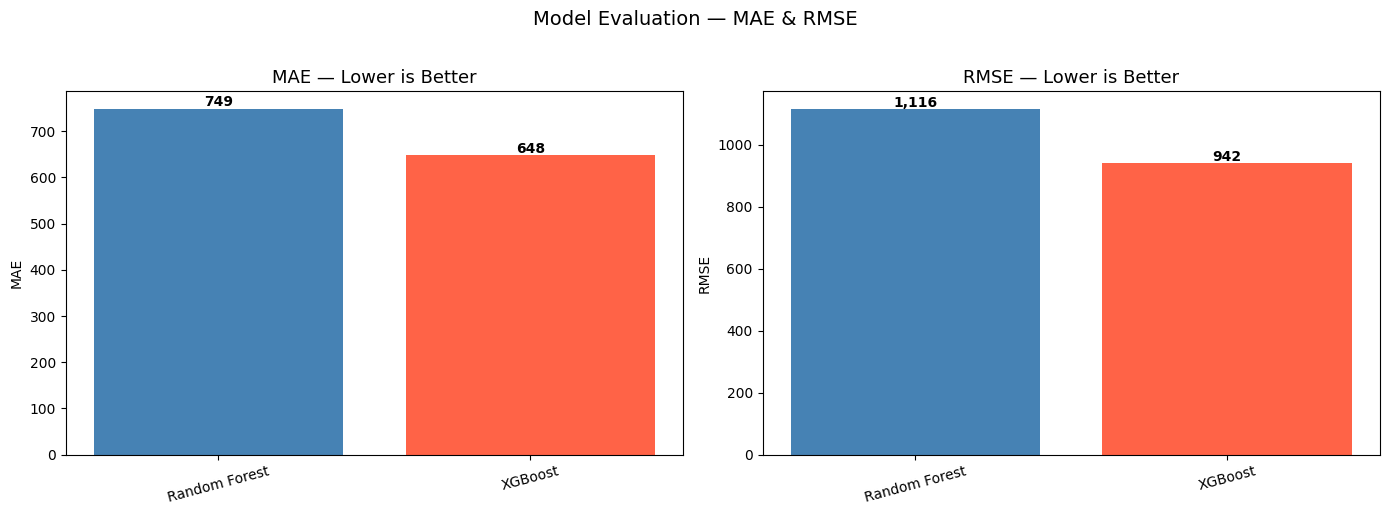

In [14]:
plot_df = results_df.dropna(subset=['MAE', 'RMSE'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['steelblue', 'tomato', 'gray']

axes[0].bar(plot_df['Model'], plot_df['MAE'],  color=colors[:len(plot_df)])
axes[0].set_title('MAE — Lower is Better')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(plot_df['MAE']):
    axes[0].text(i, v + 5, f'{v:,.0f}', ha='center', fontweight='bold')

axes[1].bar(plot_df['Model'], plot_df['RMSE'], color=colors[:len(plot_df)])
axes[1].set_title('RMSE — Lower is Better')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(plot_df['RMSE']):
    axes[1].text(i, v + 5, f'{v:,.0f}', ha='center', fontweight='bold')

plt.suptitle('Model Evaluation — MAE & RMSE', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=150)
plt.show()

## 10. Feature Importance

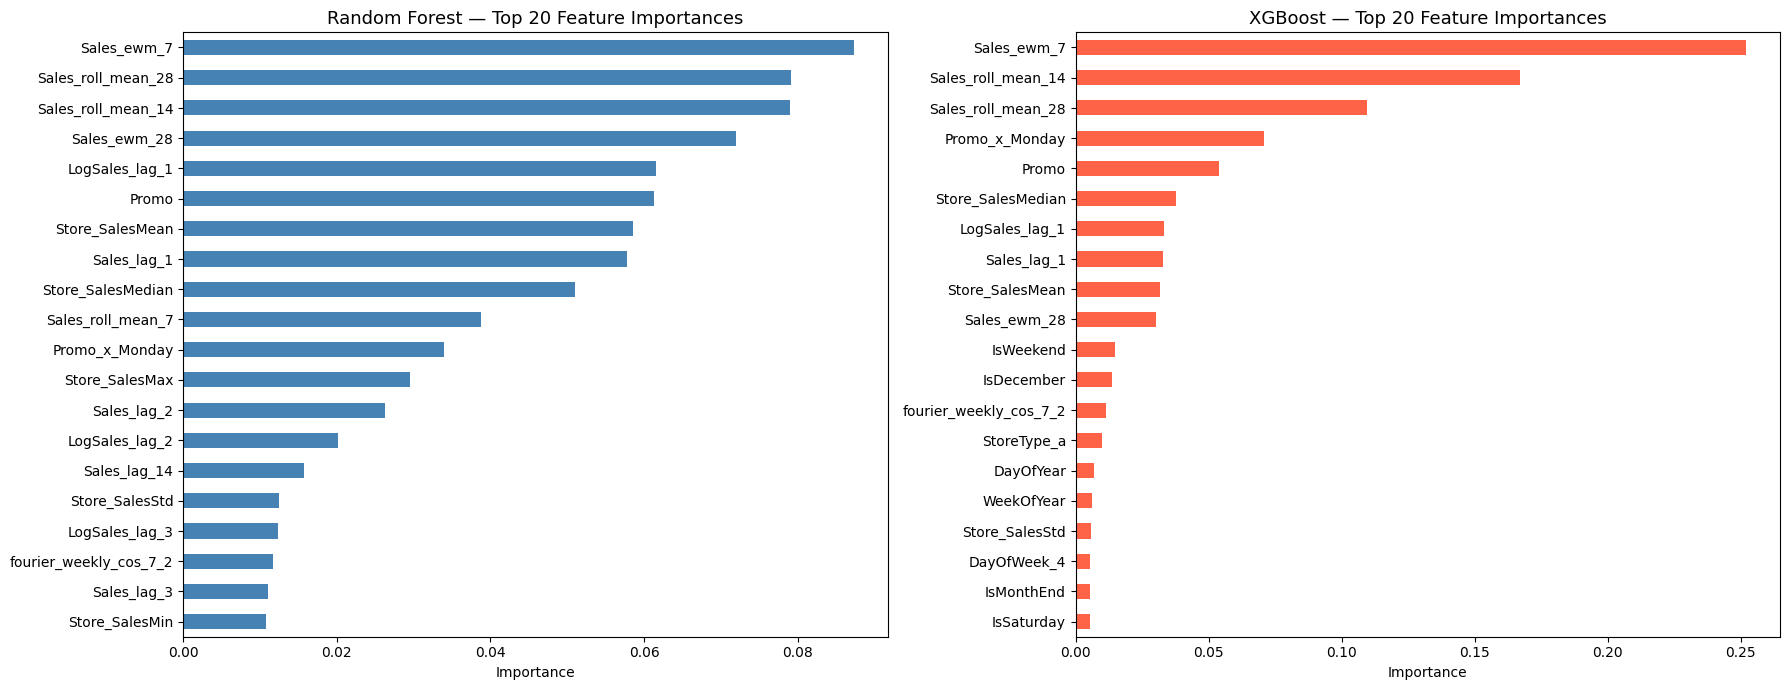

In [15]:
TOP_N = 20

# --- Random Forest importance ---
rf_imp = pd.Series(rf_model.feature_importances_, index=feature_cols)\
           .sort_values(ascending=False).head(TOP_N)

# --- XGBoost importance ---
xgb_imp = pd.Series(xgb_model.feature_importances_, index=feature_cols)\
            .sort_values(ascending=False).head(TOP_N)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

rf_imp.sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title(f'Random Forest — Top {TOP_N} Feature Importances')
axes[0].set_xlabel('Importance')

xgb_imp.sort_values().plot(kind='barh', ax=axes[1], color='tomato')
axes[1].set_title(f'XGBoost — Top {TOP_N} Feature Importances')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=150)
plt.show()

In [16]:
# Print top features
print('Top 10 — Random Forest:')
print(rf_imp.head(10).round(4).to_string())

print('\nTop 10 — XGBoost:')
print(xgb_imp.head(10).round(4).to_string())

Top 10 — Random Forest:
Sales_ewm_7           0.0873
Sales_roll_mean_28    0.0791
Sales_roll_mean_14    0.0790
Sales_ewm_28          0.0720
LogSales_lag_1        0.0615
Promo                 0.0613
Store_SalesMean       0.0586
Sales_lag_1           0.0577
Store_SalesMedian     0.0511
Sales_roll_mean_7     0.0388

Top 10 — XGBoost:
Sales_ewm_7           0.2521
Sales_roll_mean_14    0.1669
Sales_roll_mean_28    0.1095
Promo_x_Monday        0.0709
Promo                 0.0539
Store_SalesMedian     0.0378
LogSales_lag_1        0.0332
Sales_lag_1           0.0329
Store_SalesMean       0.0317
Sales_ewm_28          0.0300


## 11. Residual Analysis

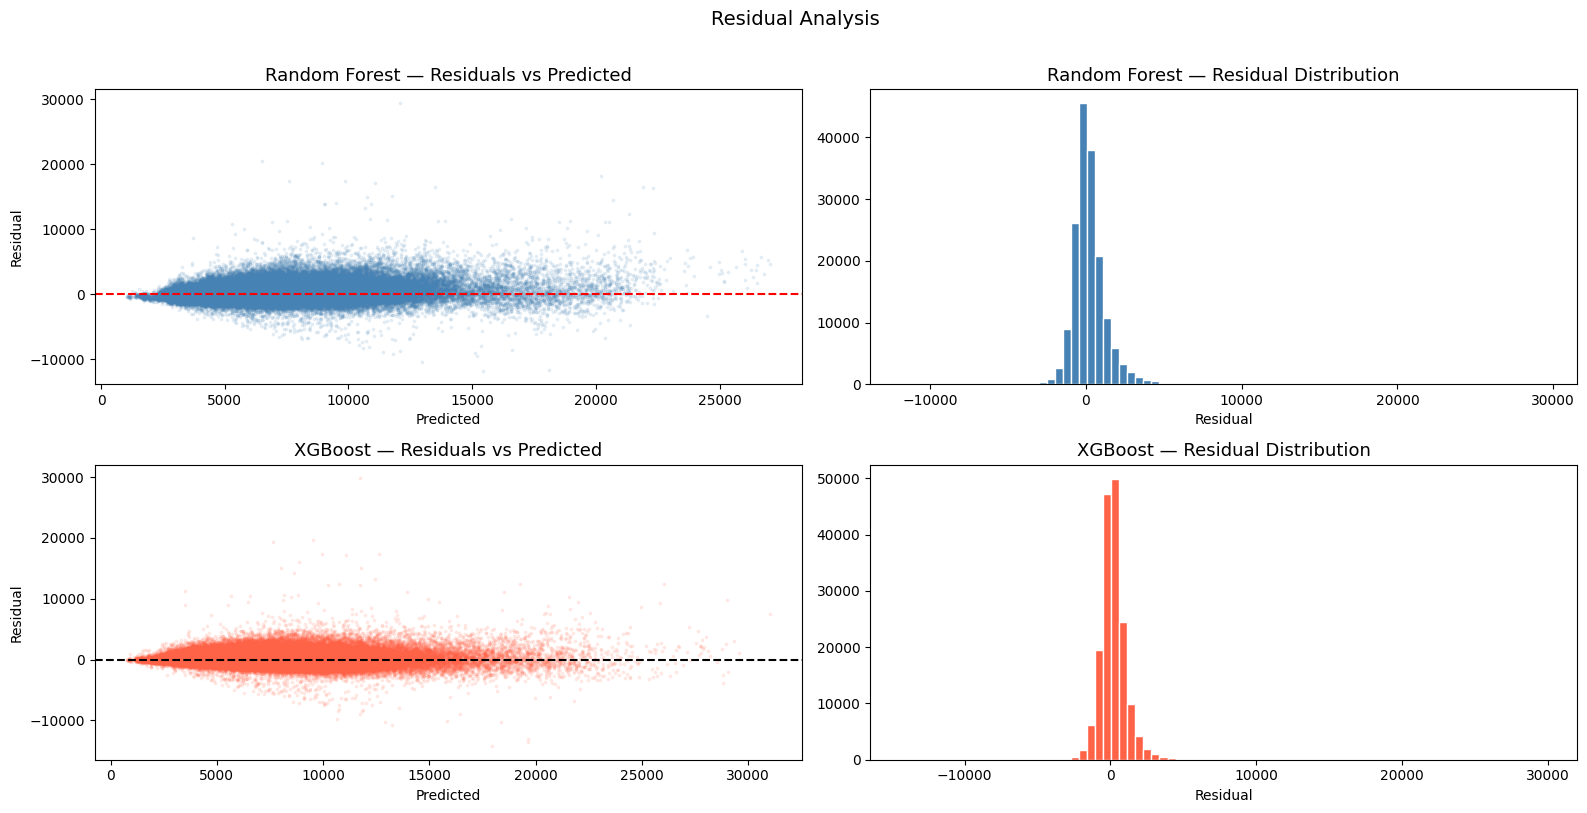

In [17]:
rf_residuals  = y_val_actual - rf_pred
xgb_residuals = y_val_actual - xgb_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# RF residuals over predictions
axes[0, 0].scatter(rf_pred, rf_residuals, alpha=0.1, s=3, color='steelblue')
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Random Forest — Residuals vs Predicted')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Residual')

# RF residual distribution
axes[0, 1].hist(rf_residuals, bins=80, color='steelblue', edgecolor='white')
axes[0, 1].set_title('Random Forest — Residual Distribution')
axes[0, 1].set_xlabel('Residual')

# XGB residuals over predictions
axes[1, 0].scatter(xgb_pred, xgb_residuals, alpha=0.1, s=3, color='tomato')
axes[1, 0].axhline(0, color='black', linestyle='--')
axes[1, 0].set_title('XGBoost — Residuals vs Predicted')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Residual')

# XGB residual distribution
axes[1, 1].hist(xgb_residuals, bins=80, color='tomato', edgecolor='white')
axes[1, 1].set_title('XGBoost — Residual Distribution')
axes[1, 1].set_xlabel('Residual')

plt.suptitle('Residual Analysis', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../reports/figures/residual_analysis.png', dpi=150)
plt.show()

## 12. Save Models

In [18]:
with open('../models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('../models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

results_df.to_csv('../reports/ml_results.csv', index=False)

print('Saved:')
print('  ✅ models/random_forest.pkl')
print('  ✅ models/xgboost.pkl')
print('  ✅ reports/ml_results.csv')

Saved:
  ✅ models/random_forest.pkl
  ✅ models/xgboost.pkl
  ✅ reports/ml_results.csv


## 13. Summary

### Models trained : Random Forest, XGBoost                   
Target         : log1p(Sales) → expm1 for evaluation      
Train samples  : 675,958                              
Val samples    : 168,380                               
Features used  : 94 

Best ML Model  : XGBoost                                  
MAE            :     647.59                          
RMSE           :     942.15 

Key Insight: Lag & rolling features were top predictors   
Promo, DayOfWeek, Store aggregates also highly important